<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/adding_C4/C4/W4/ungraded_labs/C4_W4_Lab_2_Sunspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [2]:
#!pip install tensorflow==2.5.0

In [3]:
import tensorflow as tf
print(tf.__version__)

2021-09-22 19:00:31.493265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-22 19:00:31.493296: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.5.0


In [4]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
# Sunspots.csv
# !gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

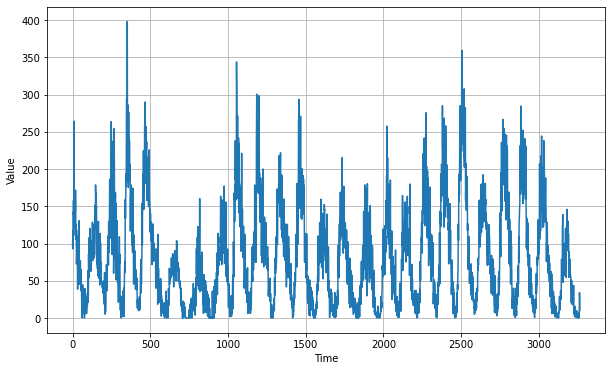

In [6]:
import csv
time_step = []
sunspots = []

with open('assets/Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

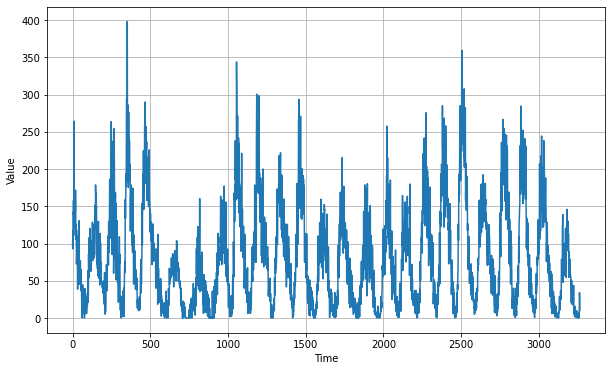

In [7]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [8]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


2021-09-22 19:01:00.785596: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-22 19:01:00.785636: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-22 19:01:00.785671: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (prashant-thinkpad): /proc/driver/nvidia/version does not exist
2021-09-22 19:01:00.786092: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


2021-09-22 19:01:01.604478: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-22 19:01:01.622122: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1999965000 Hz


Epoch 1/100
12/12 [==============================] - 5s 173ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 2s 151ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 2s 149ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 2s 142ms/step - loss: 72.2678 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 2s 152ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 2s 136ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 2s 140ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 2s 144ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/100
12/12 [==============================] - 2s 145ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/12 [==============================] - 2s 152ms/step - loss: 52.3436 - mae: 52.8399
Epoch 11/100
12/12 

(1e-08, 0.0001, 0.0, 60.0)

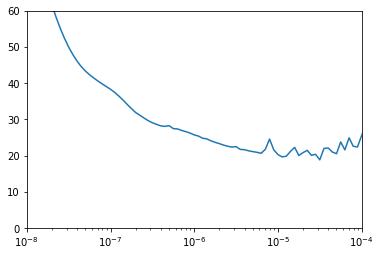

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 5s 76ms/step - loss: 38.9182 - mae: 39.4146
Epoch 2/500
30/30 [==============================] - 2s 75ms/step - loss: 25.7632 - mae: 26.2576
Epoch 3/500
30/30 [==============================] - 2s 74ms/step - loss: 22.0828 - mae: 22.5765
Epoch 4/500
30/30 [==============================] - 2s 72ms/step - loss: 20.4753 - mae: 20.9683
Epoch 5/500
30/30 [==============================] - 2s 72ms/step - loss: 19.7351 - mae: 20.2276
Epoch 6/500
30/30 [==============================] - 2s 75ms/step - loss: 19.3190 - mae: 19.8111
Epoch 7/500
30/30 [==============================] - 2s 73ms/step - loss: 18.7162 - mae: 19.2082
Epoch 8/500
30/30 [==============================] - 2s 73ms/step - loss: 18.1479 - mae: 18.6396
Epoch 9/500
30/30 [==============================] - 2s 71ms/step - loss: 18.1321 - mae: 18.6237
Epoch 10/500
30/30 [==============================] - 2s 74ms/step - loss: 18.6608 - mae: 19.1524
Epoch 11/500
30/30 [=========

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

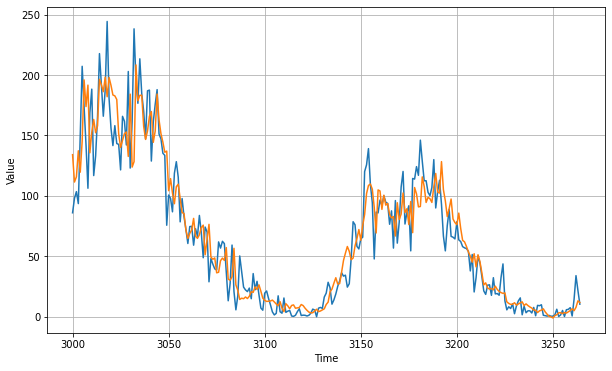

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

13.972758

<Figure size 432x288 with 0 Axes>

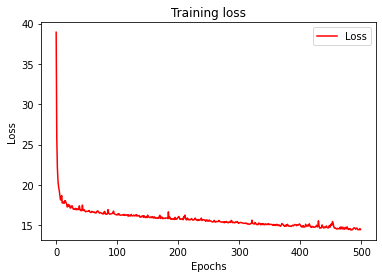

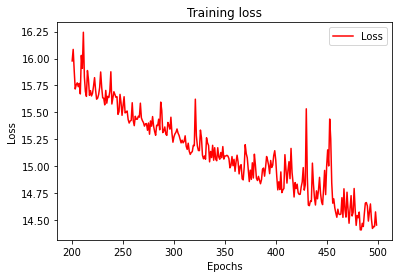

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [18]:
print(rnn_forecast)

[ 1.34084625e+02  1.11451149e+02  1.15777252e+02  1.37314880e+02
  1.19602798e+02  1.45332367e+02  1.95928497e+02  1.73881912e+02
  1.91631287e+02  1.35627045e+02  1.52670288e+02  1.63210876e+02
  1.52193756e+02  1.57922211e+02  1.96444183e+02  1.91859848e+02
  1.86218048e+02  1.98266098e+02  1.82008331e+02  1.97960907e+02
  1.91440445e+02  1.83447235e+02  1.82770691e+02  1.79737778e+02
  1.51357147e+02  1.40080704e+02  1.46025833e+02  1.51471497e+02
  1.52833038e+02  1.32625229e+02  1.84173462e+02  1.23807526e+02
  1.28308243e+02  2.08335022e+02  1.78746506e+02  1.83193390e+02
  1.83239014e+02  1.57682617e+02  1.46703369e+02  1.53715851e+02
  1.65816437e+02  1.69793365e+02  1.44295364e+02  1.53564758e+02
  1.84240677e+02  1.62820175e+02  1.51421829e+02  1.44486633e+02
  1.36078079e+02  1.37075546e+02  1.04280640e+02  1.14291046e+02
  1.02337990e+02  9.35016632e+01  1.07615753e+02  1.09630440e+02
  9.79692078e+01  8.62064972e+01  8.53593674e+01  7.15890503e+01
  6.47626495e+01  6.89263